# Setup

In [ ]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import torch
from torch.utils.data import Dataset
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments,
    get_linear_schedule_with_warmup
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from scipy.stats import pearsonr
from kaggle_secrets import UserSecretsClient
import wandb

SEED = 42
DATAPATH = "/kaggle/input/commonlit-evaluate-student-summaries/"
MODEL_NAME = 'bert-base-uncased'

2025-05-09 16:44:28.022312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746809068.218548      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746809068.272959      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Overview

In [ ]:
train_prompts = pd.read_csv(os.path.join(DATAPATH, "prompts_train.csv"))
train_summaries = pd.read_csv(os.path.join(DATAPATH, "summaries_train.csv"))
test_prompts = pd.read_csv(os.path.join(DATAPATH, "prompts_test.csv"))
test_summaries = pd.read_csv(os.path.join(DATAPATH, "summaries_test.csv"))
sample_submission = pd.read_csv(os.path.join(DATAPATH, "sample_submission.csv"))

In [ ]:
train_prompts

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [ ]:
print(train_prompts.loc[0, "prompt_id"])
print(train_prompts.loc[0, "prompt_question"])
print(train_prompts.loc[0, "prompt_title"])
print(train_prompts.loc[0, "prompt_text"])

39c16e
Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
On Tragedy
Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, 

In [ ]:
train_summaries

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


In [ ]:
print(train_summaries.loc[0, "student_id"])
print(train_summaries.loc[0, "text"])

000e8c3c7ddb
The third wave was an experimentto see how people reacted to a new one leader government. It gained popularity as people wanted to try new things. The students follow anything that is said and start turning on eachother to gain higher power. They had to stop the experement as too many people got to radical with it blindly following there leader


In [ ]:
print("train_summaries")
print(train_summaries.isna().sum())
print()
print("train_prompts")
print(train_prompts.isna().sum())

train_summaries
student_id    0
prompt_id     0
text          0
content       0
wording       0
dtype: int64

train_prompts
prompt_id          0
prompt_question    0
prompt_title       0
prompt_text        0
dtype: int64


In [ ]:
print("Number of unique students:", train_summaries["student_id"].unique().size)
print("Number of unique texts:", train_summaries["text"].unique().size)

Number of unique students: 7165
Number of unique texts: 7165


In [ ]:
train_summaries["prompt_id"].value_counts()

prompt_id
39c16e    2057
3b9047    2009
ebad26    1996
814d6b    1103
Name: count, dtype: int64

In [ ]:
print("Missing prompt_id:")
train_summaries.loc[~train_summaries["prompt_id"].isin(train_prompts["prompt_id"]), "prompt_id"].unique()

Missing prompt_id:


array([], dtype=object)

In [ ]:
train_summaries[["content", "wording"]].describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


# EDA & Data Preparation

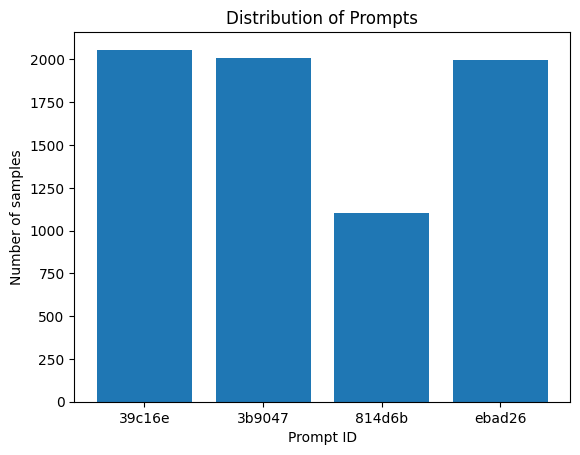

In [ ]:
prompt_ids = sorted(train_summaries["prompt_id"].unique())
plt.bar(prompt_ids, train_summaries["prompt_id"].value_counts().reindex(prompt_ids))
plt.xlabel("Prompt ID")
plt.ylabel("Number of samples")
plt.title("Distribution of Prompts")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


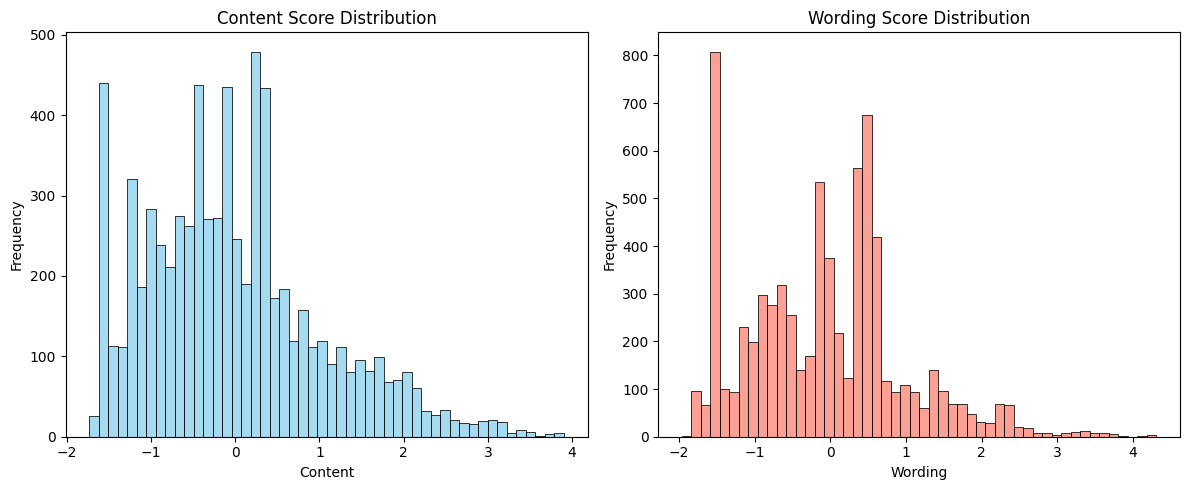

In [ ]:
def plot_scores_distributions(content_data, wording_data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Content distribution
    sns.histplot(content_data, bins=50, ax=axes[0], color='skyblue')
    axes[0].set_title('Content Score Distribution')
    axes[0].set_xlabel('Content')
    axes[0].set_ylabel('Frequency')

    sns.histplot(wording_data, bins=50, ax=axes[1], color='salmon')
    axes[1].set_title('Wording Score Distribution')
    axes[1].set_xlabel('Wording')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

plot_scores_distributions(train_summaries["content"], train_summaries["wording"])

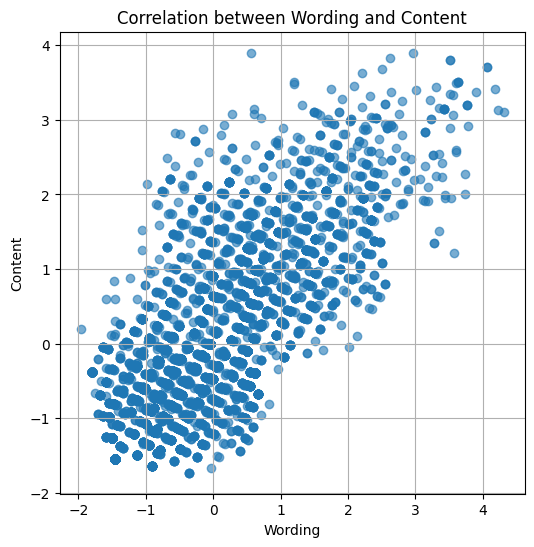

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(train_summaries['wording'], train_summaries['content'], alpha=0.6)
plt.title('Correlation between Wording and Content')
plt.xlabel('Wording')
plt.ylabel('Content')
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


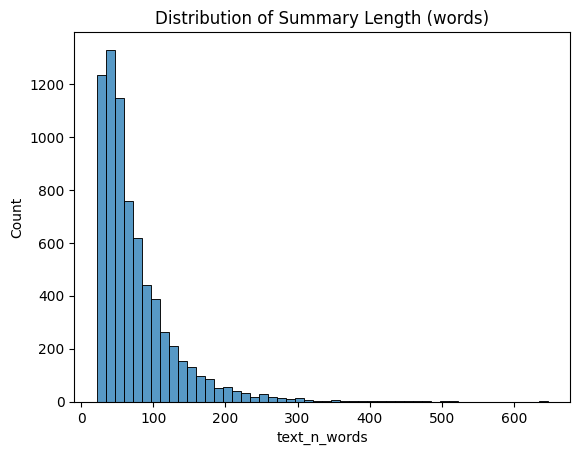

In [ ]:
train_summaries["text_n_words"] = train_summaries["text"].apply(lambda x: len(str(x).split()))
sns.histplot(train_summaries["text_n_words"], bins=50)
plt.title('Distribution of Summary Length (words)')
plt.show()

In [ ]:
train_summaries["text_n_words"].describe()

count    7165.000000
mean       74.811724
std        53.503992
min        22.000000
25%        39.000000
50%        58.000000
75%        92.000000
max       647.000000
Name: text_n_words, dtype: float64

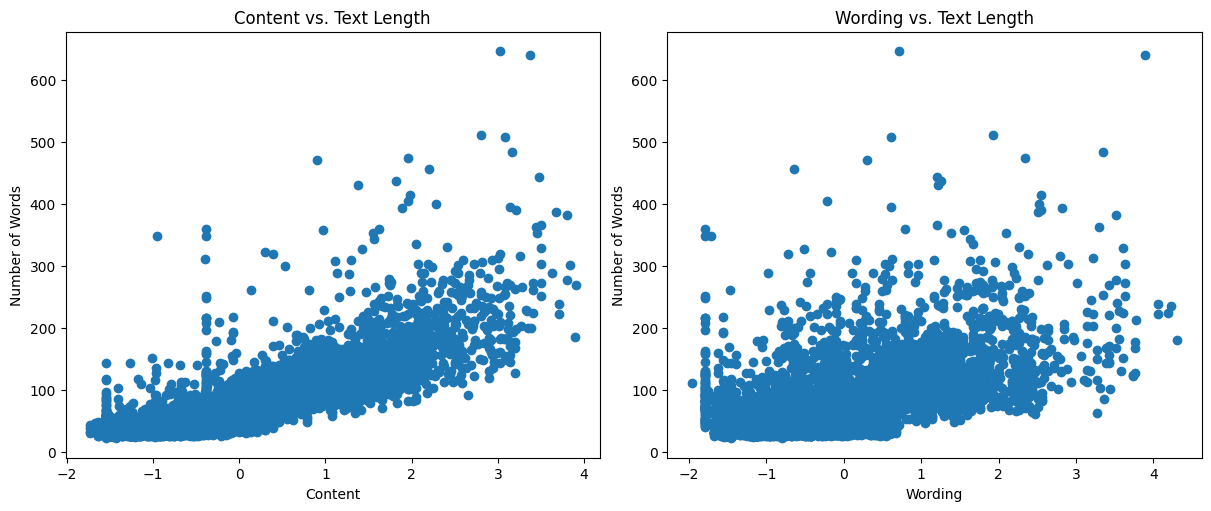

In [ ]:
def scatter_content_and_wording(content, wording, y, y_label):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5), constrained_layout=True)

    axs[0].scatter(content, y)
    axs[0].set_title("Content vs. Text Length")
    axs[0].set_xlabel("Content")
    axs[0].set_ylabel(y_label)

    axs[1].scatter(wording, y)
    axs[1].set_title("Wording vs. Text Length")
    axs[1].set_xlabel("Wording")
    axs[1].set_ylabel(y_label)

    plt.show()

scatter_content_and_wording(
    train_summaries["content"], train_summaries["wording"],
    train_summaries["text_n_words"], "Number of Words"
)

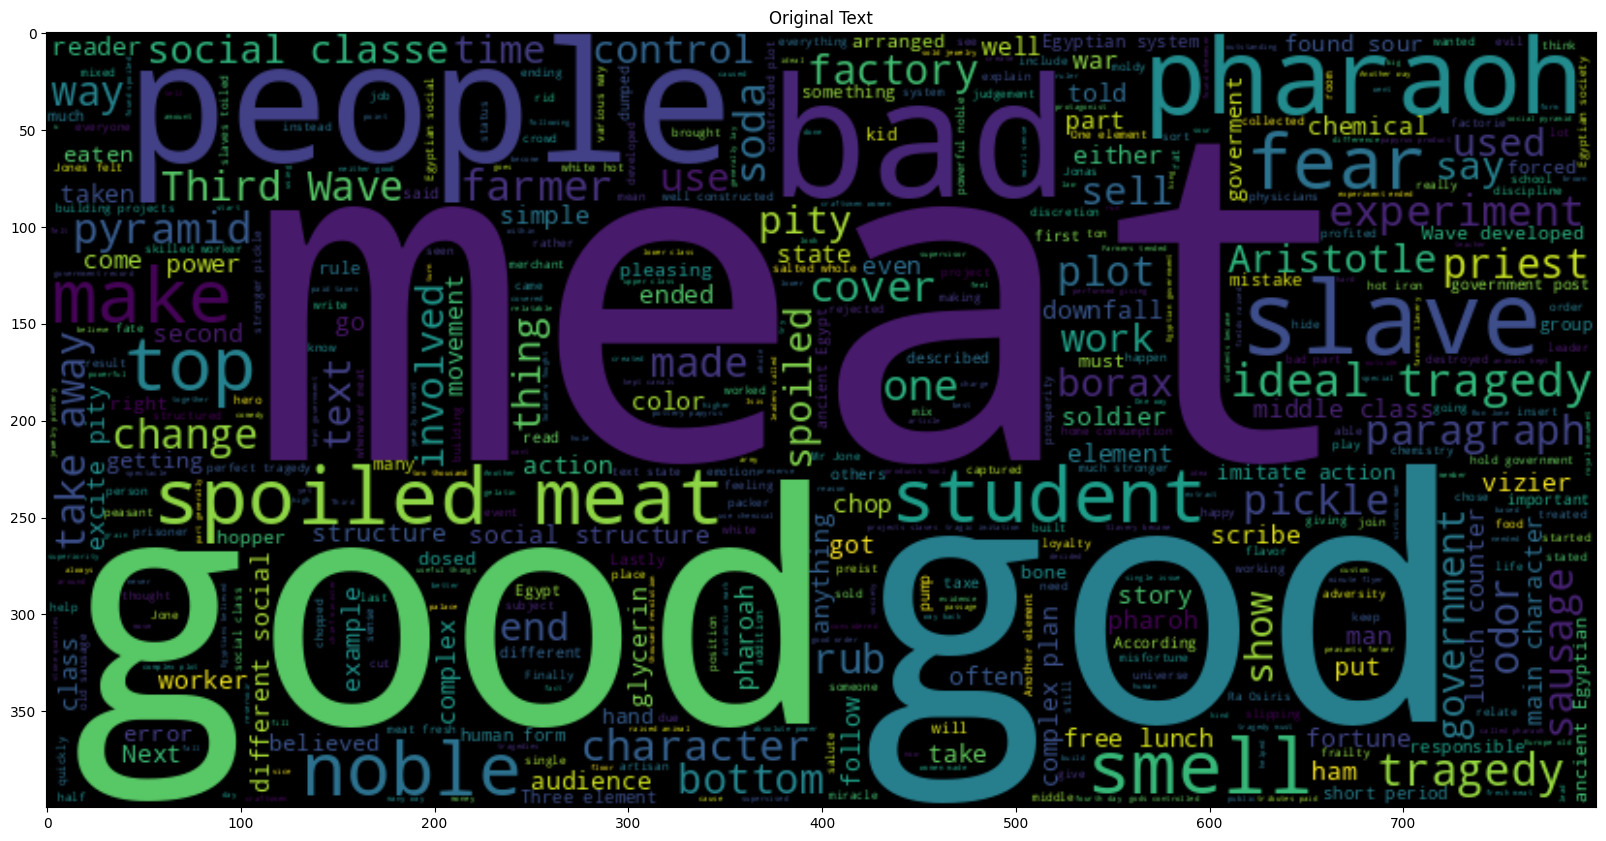

In [ ]:
def plot_word_cloud(text, title="Text"):
    plt.figure(figsize=(20, 20))
    plt.title(title)
    wc = WordCloud(max_words=500, width=800, height=400).generate(text)
    plt.imshow(wc, interpolation='bilinear')

plot_word_cloud(" ".join(train_summaries["text"]), "Original Text")

In [ ]:
train_df = train_summaries[["student_id", "prompt_id", "text", "content", "wording"]]
test_df = test_summaries[["student_id", "prompt_id", "text"]]
train_df.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


# Dataset

Custom Dataset for PyTorch

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class SummaryDataset(Dataset):
    def __init__(self, texts, labels=None, labels_dtype=torch.float):
        self.encodings = tokenizer(
            texts,
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
        self.labels = torch.tensor(labels.values, dtype=labels_dtype) if labels is not None else None

    def __len__(self):
        return self.encodings['input_ids'].size(0)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

In [ ]:
train_dataset = SummaryDataset(train_df['text'].tolist(), train_df[['content','wording']])
test_dataset = SummaryDataset(test_df['text'].tolist())
train_dataset[0]

{'input_ids': tensor([  101,  1996,  2353,  4400,  2001,  2019,  7551,  3406,  2156,  2129,
          2111, 14831,  2000,  1037,  2047,  2028,  3003,  2231,  1012,  2009,
          4227,  6217,  2004,  2111,  2359,  2000,  3046,  2047,  2477,  1012,
          1996,  2493,  3582,  2505,  2008,  2003,  2056,  1998,  2707,  3810,
          2006,  2169, 14573,  2121,  2000,  5114,  3020,  2373,  1012,  2027,
          2018,  2000,  2644,  1996,  4654,  4842, 13665,  2004,  2205,  2116,
          2111,  2288,  2000,  7490,  2007,  2009, 25734,  2206,  2045,  3003,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

# Metric

According to the competition description, the evaluation metric used in the competition is MCRMSE:
$$\text{MCRMSE} = \frac{1}{N_t} \sum_{j=1}^{N_t} \left( \frac{1}{n} \sum_{i=1}^{n} \left( y_{ij} - \hat{y}_{ij} \right)^2 \right)^{\frac{1}{2}}$$
where $N_t$ is the number of scored ground truth target columns, and $y$ and $\hat{y}$ are the actual and predicted values, respectively.

We also compute separate MSE values for `content` and `wording`, as well as Pearson correlation coefficients.

In [ ]:
def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = preds.astype(float)
    labels = labels.astype(float)
    mse_c = mean_squared_error(labels[:,0], preds[:,0])
    mse_w = mean_squared_error(labels[:,1], preds[:,1])
    mcrmse = (np.sqrt(mse_c) + np.sqrt(mse_w)) / 2

    p_c, _ = pearsonr(labels[:,0], preds[:,0])
    p_w, _ = pearsonr(labels[:,1], preds[:,1])
    return {'mse_content': mse_c, 'mse_wording': mse_w,
            'mcrmse': mcrmse,
            'pearson_content': p_c, 'pearson_wording': p_w}

In [ ]:
n_samples = 5
labels = np.random.rand(n_samples, 2)
preds = labels + np.random.normal(0, 0.1, size=(n_samples, 2))

print("Dummy labels:\n", labels)
print("Dummy predictions:\n", preds)

compute_metrics((preds, labels))

Dummy labels:
 [[0.56670755 0.84345201]
 [0.63018049 0.9744972 ]
 [0.25139148 0.24668844]
 [0.43604414 0.80040766]
 [0.66003589 0.36968194]]
Dummy predictions:
 [[0.60331598 0.79568766]
 [0.64525607 0.85798069]
 [0.18766146 0.30436155]
 [0.4984293  0.63063637]
 [0.58381608 0.23910108]]


{'mse_content': 0.0030660665483955214,
 'mse_wording': 0.013011474635976078,
 'mcrmse': 0.08471996237079016,
 'pearson_content': 0.943238361761393,
 'pearson_wording': 0.9632045083775888}

## Validation Strategy

The validation strategy used in this work is Group K-Fold Validation. Since the train and test datasets contain different prompts, we split the data by `prompt_id` to ensure the model is validated on previously unseen prompts.

# Train

In [ ]:
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("WANDB_API_KEY"))
os.environ["WANDB_PROJECT"] = "nlp-iasa-lab1"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: maridodonova (maridodonova-igor-sikorsky-kyiv-polytechnic-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
NUM_EPOCHS = 3
BATCH_SIZE = 8
BERT_LR = 2e-5
HEAD_LR = 5e-4

val_metrics = {}

for prompt_id in train_df["prompt_id"].unique():
    train_data = train_df[train_df["prompt_id"] != prompt_id]
    val_data = train_df[train_df["prompt_id"] == prompt_id]

    train_dataset = SummaryDataset(
        train_data['text'].tolist(), train_data[['content','wording']]
    )
    val_dataset = SummaryDataset(
        val_data['text'].tolist(), val_data[['content','wording']]
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        problem_type='regression'
    )

    optimizer = AdamW([
        {"params": list(model.bert.parameters()), "lr": BERT_LR},
        {"params": list(model.classifier.parameters()), "lr": HEAD_LR}
    ])

    num_steps = int(NUM_EPOCHS * len(train_dataset) / BATCH_SIZE)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * num_steps),
        num_training_steps=num_steps
    )

    training_args = TrainingArguments(
        output_dir=f'/kaggle/working/results/{prompt_id}',
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        logging_dir=f'/kaggle/working/logs/{prompt_id}',
        logging_steps=400,
        eval_steps=400,      # evaluation every 400 steps
        save_steps=400,      # checkpoint every 400 steps
        save_total_limit=2,  # keep only 2 checkpoints
        load_best_model_at_end=True,
        greater_is_better=False,
        eval_strategy="steps",
        save_strategy="steps",
        metric_for_best_model="mcrmse",
        report_to="wandb",
        run_name=f"v5-{prompt_id}"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        optimizers=(optimizer, scheduler),
        compute_metrics=compute_metrics
    )

    trainer.train()
    metrics = trainer.evaluate()

    best_model_path = f"/kaggle/working/results/best_model_{prompt_id}"
    trainer.save_model(best_model_path)
    val_metrics[prompt_id] = {
        "metrics": metrics,
        "best_model_path": best_model_path
    }
    print("prompt_id:", prompt_id)
    print("Validation metrics:", metrics)

    wandb.finish()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Changes to your `wandb` environment variables will be ignored because your `wandb` session has already started. For more information on how to modify your settings with `wandb.init()` arguments, please refer to https://wandb.me/wandb-init.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250509_164501-4ek63ltj
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run v5-814d6b
wandb: ⭐️ View project at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/nlp-iasa-lab1
wandb: 🚀 View run at

Step,Training Loss,Validation Loss,Mse Content,Mse Wording,Mcrmse,Pearson Content,Pearson Wording
400,0.512100,0.601611,0.414900,0.788322,0.766001,0.895095,0.749505
800,0.310500,0.397989,0.295556,0.500421,0.625528,0.900573,0.779885
1200,0.222200,0.502399,0.441094,0.563704,0.707476,0.893462,0.766654
1600,0.210000,0.453059,0.420996,0.485121,0.672674,0.890000,0.778826
2000,0.163500,0.466996,0.450687,0.483304,0.683267,0.898854,0.780537


prompt_id: 814d6b
Validation metrics: {'eval_loss': 0.39798852801322937, 'eval_mse_content': 0.2955562900821218, 'eval_mse_wording': 0.5004208001068882, 'eval_mcrmse': 0.6255275795554678, 'eval_pearson_content': 0.9005734733148497, 'eval_pearson_wording': 0.7798849437129355, 'eval_runtime': 7.7708, 'eval_samples_per_second': 141.941, 'eval_steps_per_second': 17.759, 'epoch': 3.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▁▅▃▃▁
wandb:             eval/mcrmse █▁▅▃▄▁
wandb:        eval/mse_content ▆▁█▇█▁
wandb:        eval/mse_wording █▁▃▁▁▁
wandb:    eval/pearson_content ▄█▃▁▇█
wandb:    eval/pearson_wording ▁█▅███
wandb:            eval/runtime ▂▃▁▅██
wandb: eval/samples_per_second ▇▆█▄▁▁
wandb:   eval/steps_per_second ▇▆█▄▁▁
wandb:             train/epoch ▁▁▂▂▄▄▅▅▇▇██
wandb:       train/global_step ▁▁▂▂▄▄▅▅▇▇██
wandb:         train/grad_norm ▁▄▅█▂
wandb:     train/learning_rate █▆▄▃▁
wandb:              train/loss █▄▂▂▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.39799
wandb:              eval/mcrmse 0.62553
wandb:         eval/mse_content 0.29556
wandb:         eval/mse_wording 0.50042
wandb:     eval/pearson_content 0.90057
wandb:     eval/pearson_wording 0.77988
wandb:             eval/runtime 7.7708
wandb:  eval/samples_per_second 141.9

Step,Training Loss,Validation Loss,Mse Content,Mse Wording,Mcrmse,Pearson Content,Pearson Wording
400,0.622000,0.335501,0.251474,0.419528,0.574591,0.874504,0.731200
800,0.305400,0.347519,0.306602,0.388437,0.588482,0.878028,0.762226
1200,0.251100,0.335766,0.258929,0.412604,0.575596,0.874174,0.749948
1600,0.194500,0.365063,0.264498,0.465628,0.598332,0.874097,0.734198


prompt_id: ebad26
Validation metrics: {'eval_loss': 0.33550113439559937, 'eval_mse_content': 0.25147409674637, 'eval_mse_wording': 0.4195281626514647, 'eval_mcrmse': 0.5745909336468586, 'eval_pearson_content': 0.8745037688761907, 'eval_pearson_wording': 0.7312004072133989, 'eval_runtime': 14.034, 'eval_samples_per_second': 142.226, 'eval_steps_per_second': 17.814, 'epoch': 3.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss ▁▄▁█▁
wandb:             eval/mcrmse ▁▅▁█▁
wandb:        eval/mse_content ▁█▂▃▁
wandb:        eval/mse_wording ▄▁▃█▄
wandb:    eval/pearson_content ▂█▁▁▂
wandb:    eval/pearson_wording ▁█▅▂▁
wandb:            eval/runtime ▄▆▁▃█
wandb: eval/samples_per_second ▅▃█▆▁
wandb:   eval/steps_per_second ▅▃█▆▁
wandb:             train/epoch ▁▁▃▃▅▅▆▆██
wandb:       train/global_step ▁▁▃▃▅▅▆▆██
wandb:         train/grad_norm ▇█▂▁
wandb:     train/learning_rate █▆▃▁
wandb:              train/loss █▃▂▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.3355
wandb:              eval/mcrmse 0.57459
wandb:         eval/mse_content 0.25147
wandb:         eval/mse_wording 0.41953
wandb:     eval/pearson_content 0.8745
wandb:     eval/pearson_wording 0.7312
wandb:             eval/runtime 14.034
wandb:  eval/samples_per_second 142.226
wandb:    eval/s

Step,Training Loss,Validation Loss,Mse Content,Mse Wording,Mcrmse,Pearson Content,Pearson Wording
400,0.468900,0.918303,0.475059,1.361547,0.928049,0.886208,0.586208
800,0.283200,0.589060,0.350371,0.827749,0.750864,0.879825,0.602295
1200,0.223900,0.514333,0.272441,0.756224,0.695785,0.883230,0.605829
1600,0.170000,0.636044,0.290768,0.981320,0.764923,0.881240,0.588981


prompt_id: 3b9047
Validation metrics: {'eval_loss': 0.5143325328826904, 'eval_mse_content': 0.27244138573577825, 'eval_mse_wording': 0.7562236136474618, 'eval_mcrmse': 0.6957851827355772, 'eval_pearson_content': 0.883229875010501, 'eval_pearson_wording': 0.6058288749288245, 'eval_runtime': 14.1065, 'eval_samples_per_second': 142.417, 'eval_steps_per_second': 17.864, 'epoch': 3.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss █▂▁▃▁
wandb:             eval/mcrmse █▃▁▃▁
wandb:        eval/mse_content █▄▁▂▁
wandb:        eval/mse_wording █▂▁▄▁
wandb:    eval/pearson_content █▁▅▃▅
wandb:    eval/pearson_wording ▁▇█▂█
wandb:            eval/runtime █▆▃▁▅
wandb: eval/samples_per_second ▁▃▆█▄
wandb:   eval/steps_per_second ▁▃▆█▄
wandb:             train/epoch ▁▁▃▃▅▅▆▆██
wandb:       train/global_step ▁▁▃▃▅▅▆▆██
wandb:         train/grad_norm █▃▅▁
wandb:     train/learning_rate █▆▃▁
wandb:              train/loss █▄▂▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.51433
wandb:              eval/mcrmse 0.69579
wandb:         eval/mse_content 0.27244
wandb:         eval/mse_wording 0.75622
wandb:     eval/pearson_content 0.88323
wandb:     eval/pearson_wording 0.60583
wandb:             eval/runtime 14.1065
wandb:  eval/samples_per_second 142.417
wandb:    ev

Step,Training Loss,Validation Loss,Mse Content,Mse Wording,Mcrmse,Pearson Content,Pearson Wording
400,0.512700,0.339987,0.193734,0.486239,0.568730,0.893234,0.830039
800,0.306000,0.359875,0.397588,0.322162,0.599069,0.899418,0.847256
1200,0.254900,0.336418,0.290498,0.382338,0.578657,0.903272,0.845294
1600,0.205100,0.392134,0.237010,0.547258,0.613302,0.899682,0.844063


prompt_id: 39c16e
Validation metrics: {'eval_loss': 0.3399867117404938, 'eval_mse_content': 0.1937339672440724, 'eval_mse_wording': 0.4862394969132989, 'eval_mcrmse': 0.5687304810540674, 'eval_pearson_content': 0.8932335396547026, 'eval_pearson_wording': 0.830038575113921, 'eval_runtime': 14.4894, 'eval_samples_per_second': 141.966, 'eval_steps_per_second': 17.806, 'epoch': 3.0}


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:               eval/loss ▁▄▁█▁
wandb:             eval/mcrmse ▁▆▃█▁
wandb:        eval/mse_content ▁█▄▂▁
wandb:        eval/mse_wording ▆▁▃█▆
wandb:    eval/pearson_content ▁▅█▅▁
wandb:    eval/pearson_wording ▁█▇▇▁
wandb:            eval/runtime ▁█▇▆▃
wandb: eval/samples_per_second █▁▂▃▆
wandb:   eval/steps_per_second █▁▂▃▆
wandb:             train/epoch ▁▁▃▃▅▅▇▇██
wandb:       train/global_step ▁▁▃▃▅▅▇▇██
wandb:         train/grad_norm ▃█▃▁
wandb:     train/learning_rate █▆▃▁
wandb:              train/loss █▃▂▁
wandb: 
wandb: Run summary:
wandb:                eval/loss 0.33999
wandb:              eval/mcrmse 0.56873
wandb:         eval/mse_content 0.19373
wandb:         eval/mse_wording 0.48624
wandb:     eval/pearson_content 0.89323
wandb:     eval/pearson_wording 0.83004
wandb:             eval/runtime 14.4894
wandb:  eval/samples_per_second 141.966
wandb:    ev

In [ ]:
best_prompt_id = min(val_metrics, key=lambda pid: val_metrics[pid]["metrics"]["eval_mcrmse"])
best_model_path = val_metrics[best_prompt_id]["best_model_path"]

best_model = AutoModelForSequenceClassification.from_pretrained(best_model_path)
trainer = Trainer(
    model=best_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics
)

In [ ]:
val_preds = trainer.predict(val_dataset).predictions
val_out = val_data[['student_id','prompt_id','content','wording']].copy()
val_out['content_pred'] = val_preds[:,0]
val_out['wording_pred'] = val_preds[:,1]
val_out.to_csv('val_predictions_full.csv', index=False)
val_out

wandb: WARNING Changes to your `wandb` environment variables will be ignored because your `wandb` session has already started. For more information on how to modify your settings with `wandb.init()` arguments, please refer to https://wandb.me/wandb-init.
wandb: Tracking run with wandb version 0.19.6
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250509_172344-8kgwephz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run v5-39c16e
wandb: ⭐️ View project at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/nlp-iasa-lab1
wandb: 🚀 View run at https://wandb.ai/maridodonova-igor-sikorsky-kyiv-polytechnic-institute/nlp-iasa-lab1/runs/8kgwephz


,student_id,prompt_id,content,wording,content_pred,wording_pred
8,00791789cc1f,39c16e,-0.210614,-0.471415,-0.069732,0.537086
9,0086ef22de8f,39c16e,-0.970237,-0.417058,-1.035784,-0.725575
13,0094589c7a22,39c16e,-0.387791,-0.584181,-0.489238,-0.104953
19,00cd5736026a,39c16e,0.088882,-0.594710,0.117441,0.883162
21,00d98b8ff756,39c16e,-0.687288,-0.460886,-0.260131,0.135296
...,...,...,...,...,...,...
7143,fef3e85236e5,39c16e,-0.981265,-1.548900,-1.271808,-0.890254
7145,ff0f65eecf02,39c16e,-0.511077,-1.589115,-1.124477,-0.803867
7146,ff186473ea0a,39c16e,-0.834946,-0.593749,-0.947461,-0.556212
7157,ff5e9e6068da,39c16e,-0.157460,-0.165811,-0.363730,0.012284


# Results

In [ ]:
prompt_metrics = val_out.groupby('prompt_id').apply(
    lambda g: pd.Series({
        'mse_content': mean_squared_error(g['content'], g['content_pred']),
        'mse_wording': mean_squared_error(g['wording'], g['wording_pred'])
    })
).sort_values('mse_content', ascending=False)
prompt_metrics.to_csv('prompt_error_metrics.csv', index=True)

/tmp/ipykernel_19/633417028.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prompt_metrics = val_out.groupby('prompt_id').apply(


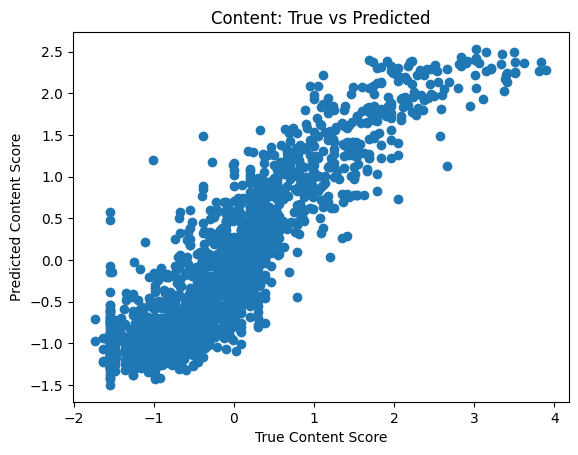

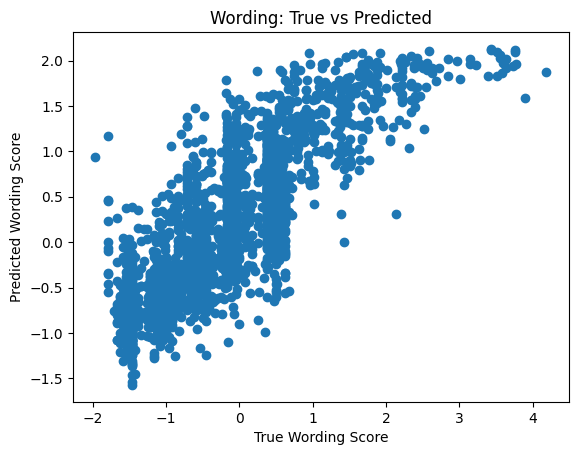

In [ ]:
plt.figure()
plt.scatter(val_out['content'], val_out['content_pred'])
plt.xlabel('True Content Score')
plt.ylabel('Predicted Content Score')
plt.title('Content: True vs Predicted')
plt.savefig('scatter_content.png')

plt.figure()
plt.scatter(val_out['wording'], val_out['wording_pred'])
plt.xlabel('True Wording Score')
plt.ylabel('Predicted Wording Score')
plt.title('Wording: True vs Predicted')
plt.savefig('scatter_wording.png')

# Submission

In [ ]:
test_preds = trainer.predict(test_dataset).predictions
submission = pd.DataFrame({
    'student_id': test_df['student_id'],
    'content': test_preds[:, 0],
    'wording': test_preds[:, 1]
})

submission.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv


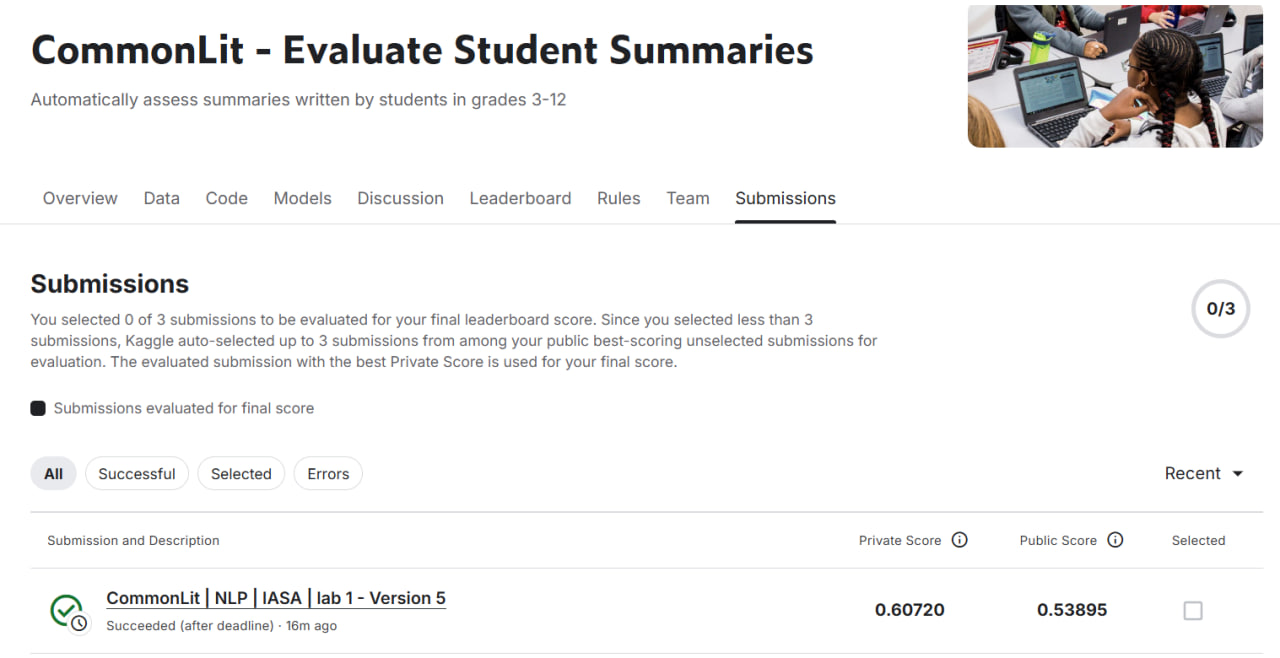

# Adversarial Validation

In [ ]:
prompt_id = train_df["prompt_id"].unique()[0]
adv_train_data = train_df[train_df["prompt_id"] != prompt_id]
adv_test_data = train_df[train_df["prompt_id"] == prompt_id]

adv_train_data["label"] = 0
adv_test_data["label"] = 1

adv_data = pd.concat([adv_train_data, adv_test_data])
adv_train, adv_val = train_test_split(adv_data, test_size=0.2, random_state=42)

adv_train_ds = SummaryDataset(adv_train['text'].tolist(), adv_train['label'], labels_dtype=torch.long)
adv_val_ds = SummaryDataset(adv_val['text'].tolist(), adv_val['label'], labels_dtype=torch.long)

adv_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

adv_training_args = TrainingArguments(
    output_dir='/kaggle/working/results/adv',
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    logging_dir='/kaggle/working/logs/adv',
    logging_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="wandb",
    run_name="v5-adv"
)

adv_trainer = Trainer(
    model=adv_model,
    args=adv_training_args,
    train_dataset=adv_train_ds,
    eval_dataset=adv_val_ds
)

adv_trainer.train()

preds = adv_trainer.predict(adv_val_ds).predictions
probs = torch.nn.functional.softmax(torch.tensor(preds), dim=-1)[:, 1].numpy()

score = roc_auc_score(adv_val_ds[:]["labels"], probs)
print(score)

wandb.finish()

/tmp/ipykernel_19/3545072530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adv_train_data["label"] = 0
/tmp/ipykernel_19/3545072530.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adv_test_data["label"] = 1
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.024800,0.013897
2,0.007700,0.033133
3,0.000000,0.005950


0.9999847252453508


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                   eval/loss ▃█▁
wandb:                eval/runtime █▅▁
wandb:     eval/samples_per_second ▁▄█
wandb:       eval/steps_per_second ▁▄█
wandb:                   test/loss █▁
wandb:                 test/mcrmse ▁
wandb: test/model_preparation_time ▁▁
wandb:            test/mse_content ▁
wandb:            test/mse_wording ▁
wandb:        test/pearson_content ▁
wandb:        test/pearson_wording ▁
wandb:                test/runtime █▁▆
wandb:     test/samples_per_second █▁█
wandb:       test/steps_per_second ▁█▁
wandb:                 train/epoch ▁▂▃▅▅▇██
wandb:           train/global_step ▁▁▃▃▄▆▆████
wandb:             train/grad_norm █▃▁▁
wandb:         train/learning_rate █▆▃▁
wandb:                  train/loss █▃▄▁
wandb: 
wandb: Run summary:
wandb:                   eval/loss 0.00595
wandb:                eval/runtime 9.9102
wandb:     eval/samples_per

The presented result (ROC AUC = 0.99998) might seem concerning in this context, but here's an explanation. To properly evaluate the model in this competition, we should use prompts that the model hasn't seen during training. The training dataset contains only four distinct prompts, each covering a specific topic (e.g., Aristotle's ideal tragedy or the development of the Third Wave). This makes it easy for the model to distinguish between training and validation data. So in this case, the high ROC AUC doesn't suggest a flawed validation strategy, but rather highlights the limited diversity in the dataset. With a broader variety of prompts, we'd expect adversarial validation results to be more balanced.